In [10]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime

- read enhancer-cell-matrix (mcg)
- read gene-cell matrix (rna)
- read kNN matrix (from previous files)
- read enhancer-gene linkage files (from previous files)

- do the analysis

# Todo

- figure out the best matrix multiplications to do

- make sure the enhancer-gene linkage file match

In [5]:
today = datetime.date.today()
print(today)

2020-07-28


## Correlate enhancer and gene (a new notebook)

In [6]:
# load from file

# save ec_mccg and gc_rna
ti = time.time()
f = '/cndd2/fangming/projects/scf_enhancers/results/ec_mccg_test1.pkl'
with open(f, 'rb') as fh:
    ec_mccg = pickle.load(fh)
print(time.time()-ti)
    
ti = time.time()
f = '/cndd2/fangming/projects/scf_enhancers/results/gc_rna_test1.pkl'
with open(f, 'rb') as fh:
    gc_rna = pickle.load(fh).todense()
print(time.time()-ti)

print(ec_mccg.shape, gc_rna.shape)

1.4322991371154785
4.671191692352295
(87943, 6244) (32324, 6244)


In [7]:
# gene-cell matrix (rna)

ti = time.time()
f = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/smarter_cells_features.npz'
fgene = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/smarter_cells_features.gene'
fcell = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/smarter_cells_features.cell'

gene_cell_rna_mat = snmcseq_utils.load_gc_matrix(fgene, fcell, f)

print(gene_cell_rna_mat.data.shape)
print(time.time()-ti)


(32324, 6244)
17.113574743270874


In [8]:
# enhancer-gene linkage
ti = time.time()
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv'
enhancer_gene_to_eval = pd.read_csv(f, sep='\t')
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals_shuffled.tsv'
enhancer_gene_to_eval_shuffled = pd.read_csv(f, sep='\t')

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 18)
19.097114086151123


,gene,ens,val,val2,val_clustershuffled,val2_clustershuffled,dist,pvalues,fdr<100kb,fdr<200kb,fdr<500kb,fdr<100kb shuffled (cluster label),pvalues2,fdr2<100kb,fdr2<200kb,fdr2<500kb,fdr2<100kb shuffled (cluster label),val_both
0,ENSMUSG00000000001,147520,-0.157895,0.127913,-0.169712,-0.049349,995118,0.288079,0.674683,0.736811,0.827139,1.647931,0.383141,0.745977,0.797076,0.872822,1.955898,-0.285808
1,ENSMUSG00000000001,147522,0.027465,-0.307145,0.064887,0.105591,985740,0.561881,0.830849,0.867082,0.917381,0.958300,0.935264,0.973809,0.979844,0.987476,0.959470,0.334610
2,ENSMUSG00000000001,147523,-0.040376,0.011489,-0.155487,0.014772,983725,0.457686,0.780196,0.825259,0.889141,1.089312,0.580703,0.841673,0.874844,0.922832,1.273339,-0.051866
3,ENSMUSG00000000001,147527,-0.070795,0.111719,-0.088084,0.184594,970444,0.411564,0.755088,0.804341,0.874375,1.183332,0.410358,0.761056,0.809464,0.880982,1.812516,-0.182514
4,ENSMUSG00000000001,147528,0.012583,0.150673,-0.036218,0.147609,969372,0.539123,0.819981,0.858026,0.911467,0.979843,0.345993,0.725803,0.780447,0.862033,2.191506,-0.138090


## Data

In [24]:
def row_dot_product_norm_by_numcol(X_zscore, Y_zscore, x_idx, y_idx):
    """compute (X_zscore[x_idx]*Y_zscore[y_idx]).mean(axis=1)
    correlation values given matched x_idx and y_idx...
    """
    assert len(x_idx) == len(y_idx)
    num_pairs = len(x_idx)
    chunksize = 10000
    verbose_level = 10*chunksize
    corrs = []
    for pair_idx in snmcseq_utils.chunks(np.arange(num_pairs), chunksize):
        if pair_idx[0] % verbose_level == 0:
            print(pair_idx[0], time.time()-ti)

        _res = (X_zscore[x_idx[pair_idx]]*Y_zscore[y_idx[pair_idx]]).mean(axis=1)
        corrs.append(_res)
    corrs = np.hstack(corrs) 
    return corrs 

In [25]:
gc_rna_zscore = stats.zscore(np.array(gc_rna), axis=1, ddof=0, nan_policy='propagate')
ec_mccg_zscore = stats.zscore(ec_mccg.values, axis=1, ddof=0, nan_policy='propagate')

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [27]:
# use ec_mccg and gc_rna
# correlate e-g according to a e-g table
ti = time.time()

gene_idx = snmcseq_utils.get_index_from_array(gene_cell_rna_mat.gene, enhancer_gene_to_eval['gene'])
enh_idx = snmcseq_utils.get_index_from_array(ec_mccg.index.values, enhancer_gene_to_eval['ens']) # be careful here!
to_correlate = ~np.logical_or(gene_idx==-1, enh_idx==-1)
gene_idx = gene_idx[to_correlate]
enh_idx = enh_idx[to_correlate]
print(gene_idx.shape, enh_idx.shape)
print(time.time()-ti)

corrs = row_dot_product_norm_by_numcol(gc_rna_zscore, ec_mccg_zscore, gene_idx, enh_idx)
print(time.time()-ti)
corrs_shuffled_cells = row_dot_product_norm_by_numcol(
    gc_rna_zscore[:,np.random.permutation(gc_rna_zscore.shape[1])], 
    ec_mccg_zscore, 
    gene_idx, enh_idx)
print(time.time()-ti)

(1543535,) (1543535,)
0.41297078132629395
0 0.41712498664855957
100000 6.138195514678955
200000 11.665125131607056
300000 17.104012727737427
400000 22.61560344696045
500000 28.037551879882812
600000 33.52464556694031
700000 39.01247978210449
800000 44.70385193824768
900000 50.398597717285156
1000000 56.114482402801514
1100000 61.86452674865723
1200000 67.59830045700073
1300000 73.34602379798889
1400000 79.13263201713562
1500000 84.8893494606018
87.3892822265625
0 87.85183191299438
100000 93.47141575813293
200000 98.95554971694946
300000 104.33573126792908
400000 109.74830865859985
500000 115.14126181602478
600000 120.52076315879822
700000 125.99895715713501
800000 131.67529702186584
900000 137.35159611701965
1000000 143.06626772880554
1100000 148.8039321899414
1200000 154.53632616996765
1300000 160.22188878059387
1400000 165.97799015045166
1500000 171.71183252334595
174.19910860061646


In [28]:
ti = time.time()

gene_idx = snmcseq_utils.get_index_from_array(gene_cell_rna_mat.gene, enhancer_gene_to_eval_shuffled['gene'])
enh_idx = snmcseq_utils.get_index_from_array(ec_mccg.index.values, enhancer_gene_to_eval_shuffled['ens']) # be careful here!
to_correlate = ~np.logical_or(gene_idx==-1, enh_idx==-1)
gene_idx = gene_idx[to_correlate]
enh_idx = enh_idx[to_correlate]
print(gene_idx.shape, enh_idx.shape)
print(time.time()-ti)

corrs_shuffled = row_dot_product_norm_by_numcol(gc_rna_zscore, ec_mccg_zscore, gene_idx, enh_idx)
print(time.time()-ti)

(1543535,) (1543535,)
0.3880932331085205
0 0.39013218879699707
100000 6.015280485153198
200000 11.494982481002808
300000 16.87687373161316
400000 22.332246780395508
500000 27.723333597183228
600000 33.1008026599884
700000 38.580302000045776
800000 44.256930351257324
900000 49.92981815338135
1000000 55.64340114593506
1100000 61.38148617744446
1200000 67.111985206604
1300000 72.80028915405273
1400000 78.55193185806274
1500000 84.2856810092926
86.76874804496765


In [29]:
# save ec_mccg and gc_rna
ti = time.time()
f = '/cndd2/fangming/projects/scf_enhancers/results/{}_corrs_test2.pkl'.format(today)
with open(f, 'wb') as fh:
    pickle.dump((corrs, corrs_shuffled, corrs_shuffled_cells), fh)
print(time.time()-ti)

0.14132404327392578


# plotting results
- different k

In [36]:
f = '/cndd2/fangming/projects/scf_enhancers/results/2020-07-28_corrs_test2.pkl'
with open(f, 'rb') as fh:
    corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

(1543535,) (1543535,) (1543535,)


In [38]:
dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
print(np.min(dists), np.max(dists))
dists

2067 999999


array([985740, 969372, 931364, ..., 242242, 294607, 972679])

In [41]:
config = {
    'kde': False,
    "hist_kws": {
                'histtype': 'step', 
#                 'edgecolor': 'none',
                'alpha': 1, 
                'density': True, 
                },
}


colors = snmcseq_utils.get_grad_colors(5, cmap='Blues_r')
tracks = {
    'pairs (<100kb)': corrs[dists<1e5], 
    'pairs (<500kb)': corrs[dists<5e5], 
    'pairs (<1Mb)': corrs, 
    'shuffled pairs': corrs_shuffled, 
    'shuffled cells': corrs_shuffled_cells, 
    }
track_colors = {
    'pairs (<100kb)': colors[0], 
    'pairs (<500kb)': colors[1], 
    'pairs (<1Mb)': colors[2], 
    'shuffled pairs': 'gray', 
    'shuffled cells': 'gray', 
    }





/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


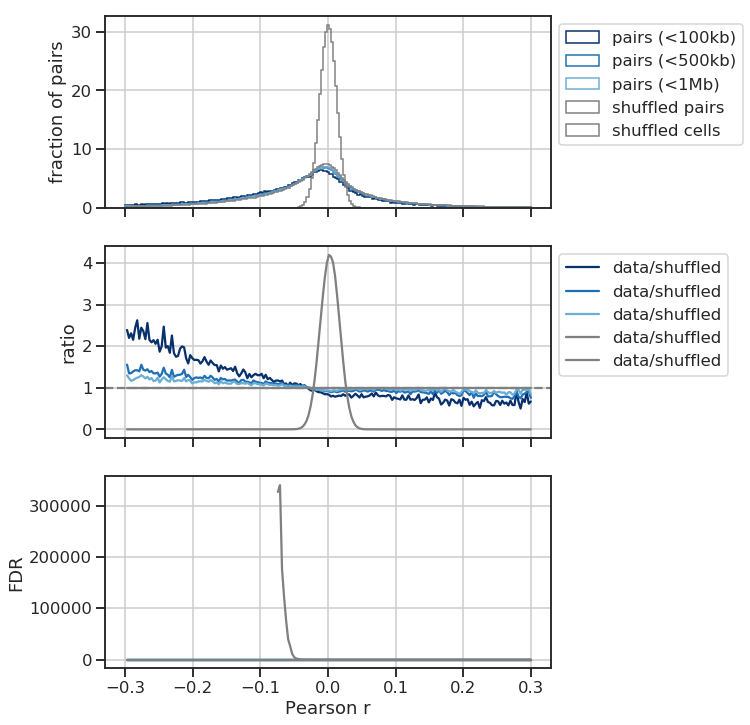

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


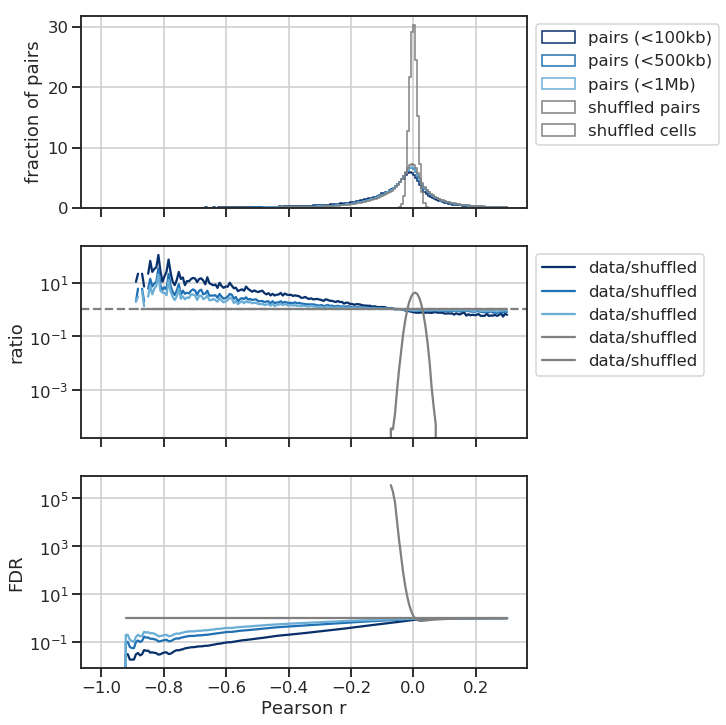

In [44]:
# figure 1
num_bins = 200
bins = np.linspace(-0.3, 0.3, num_bins)

tracks_hist_ratios = {}
track_cdfs = {}
fdr_cdfs = {}

hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
cdf_shuff = np.cumsum(hist_shuff)
for label, track in tracks.items():
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    fdr = cdf_shuff/cdf
    tracks_hist_ratios[label] = hist/hist_shuff
    track_cdfs[label] = cdf 
    fdr_cdfs[label] = fdr

fig, axs = plt.subplots(3, 1, figsize=(4*2,4*3), sharex=True)

ax = axs[0]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')

ax = axs[1]
for label, track in tracks_hist_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.axhline(1, linestyle='--', color='gray')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('ratio')

ax = axs[2]
for label, track in fdr_cdfs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')

output = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cell_level_mc_rna_corr_v1.pdf'.format(today)
plt.show()

# figure 2
num_bins = 200
bins = np.linspace(-1, 0.3, num_bins)

tracks_hist_ratios = {}
track_cdfs = {}
fdr_cdfs = {}

hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
cdf_shuff = np.cumsum(hist_shuff)
for label, track in tracks.items():
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    fdr = cdf_shuff/cdf
    tracks_hist_ratios[label] = hist/hist_shuff
    track_cdfs[label] = cdf 
    fdr_cdfs[label] = fdr
fig, axs = plt.subplots(3, 1, figsize=(4*2,4*3), sharex=True)

ax = axs[0]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')

ax = axs[1]
for label, track in tracks_hist_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.set_yscale('log')
ax.axhline(1, linestyle='--', color='gray')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('ratio')

ax = axs[2]
for label, track in fdr_cdfs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
ax.set_yscale('log')
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')

output = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cell_level_mc_rna_corr_v2.pdf'.format(today)
plt.show()